# Logistic and Softmax Regression for Handwritten Digits Classification 
Programming Assignment 1
CSE 253: Neural Networks for Pattern Recognition, by Prof. Gary Cottrell

Shilin Zhu
Ph.D. student, Computer Science, UCSD
shz338@eng.ucsd.edu

## Packages
Run the code below to import the packages we need in this assignment.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Read MNIST
MNIST is a handwritten digit database by Yann LeCun. To reduce the computation, we only use 20000 images for training and 2000 images for testing.

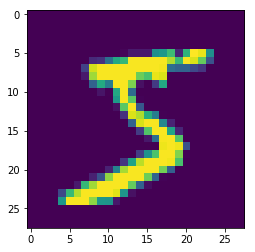

In [2]:
from mnist import MNIST
mndata = MNIST('./python-mnist/data')
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()
plt.imshow(np.array(train_images[0]).reshape([28,28]))

We only use 20000 images for training and 2000 images for testing.

In [114]:
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels).reshape([60000,1])
test_labels = np.array(test_labels).reshape([10000,1])
print(train_labels.shape)

(60000, 1)


In [107]:
print((train_images[1,:]).reshape(784,1).shape)

(784, 1)


We need to only retain the examples with two labels to perform binary classification.

In [239]:
train_size = 1000
test_size = 1000
train_images_sub = np.zeros([784,train_size])
train_labels_sub = np.zeros([1,train_size])
test_images_sub = np.zeros([784,test_size])
test_labels_sub = np.zeros([1,test_size])
counter = 0
for i in range(0,train_size):
    if train_labels[i][0] == 1 or train_labels[i][0] == 2:
        train_images_sub[:,counter] = train_images[i,:]
        train_labels_sub[:,counter] = train_labels[i,:]-1
        counter = counter + 1        
train_images_sub = train_images_sub[:,0:counter-1]
train_labels_sub = train_labels_sub[:,0:counter-1]

counter = 0
for i in range(0,test_size):
    if test_labels[i][0] == 1 or test_labels[i][0] == 2:
        test_images_sub[:,counter] = test_images[i,:]
        test_labels_sub[:,counter] = test_labels[i,:]-1
        counter = counter + 1        
test_images_sub = test_images_sub[:,0:counter-1]
test_labels_sub = test_labels_sub[:,0:counter-1]

(784, 214)


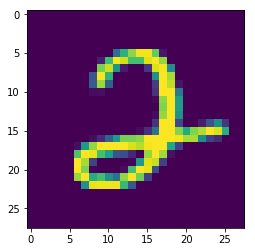

In [240]:
print(train_images_sub.shape)
plt.imshow(np.array(train_images_sub[:,5]).reshape([28,28]))

We then normalize the features (already flattened) by dividing over 255.

In [241]:
train_set_x = train_images_sub/255.
test_set_x = test_images_sub/255.
train_set_y = train_labels_sub
test_set_y = test_labels_sub

In [242]:
print(train_set_x[:,0])

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

Generally, we perform the following steps:
-initialize the parameters
-learn the parameters using logistic/softmax regression
-use the learned parameters to make predictions
-analyze and conclude

We first build some helper functions so that we will build the entire model later based on these functions.

## Activation Functions

In [7]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    a = 1/(1+np.exp(-z))  
    return a

## Initializing parameters

For logistic/softmax regression, zero initialization can work reasonably well.

In [8]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros([dim,1])
    b = 0
    
    return w, b

## Forward and Backward Propagation

Logistic regression is a simple one-layer neural network, so we reuse the term forward propagation and backward propagation here.

In [276]:
def propagate(w, b, X, Y, lambda_reg):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    
    m = X.shape[1]
    A = sigmoid(np.dot(w.T,X)+b)
    cost = -(1/m)*np.sum(np.multiply(Y,np.log(A))+np.multiply(1-Y,np.log(1-A)),keepdims=True) + (lambda_reg/(2*m)) * np.sum(np.power(w,2))                                 # compute cost

    dw = (1/m)*(np.dot(X,(A-Y).T)) + (lambda_reg/m) * w
    
    db = (1/m)*np.sum(A-Y,keepdims=True)

    cost = np.squeeze(cost)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [258]:
np.sum(np.power([[1,2],[2,3]],2))

18

## Gradient Descent Optimization

After we compute the gradients, we can use gradient descent to optimize the parameters.

In [260]:
def optimize(w, b, X, Y, lambda_reg, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    """
    
    costs = []

    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y, lambda_reg)
        
        dw = grads["dw"]
        db = grads["db"]

        w = w-learning_rate*dw
        b = b-learning_rate*db

        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 10 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

## Predictions

Using the learned parameters to predict labels for the unseen examples.

In [261]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        Y_prediction[0,i] = np.where(A[0,i]>0.5,1,0)
    
    return Y_prediction

## Build the Entire Model

Using our implemented helper functions, we can now build the entire model by combining them together.

In [277]:
def model(X_train, Y_train, X_test, Y_test, lambda_reg, num_iterations = 2000, learning_rate = 0.5, print_cost = True):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    w, b = np.zeros((X_train.shape[0],1)), 0.
    
    parameters, grads, costs = optimize(w, b, X_train, Y_train, lambda_reg, num_iterations, learning_rate, print_cost = True)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

## Training the Model

we can now use the following code to train the model.

In [280]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, lambda_reg = 0, num_iterations = 1000, learning_rate = 0.01, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 10: 0.575801
Cost after iteration 20: 0.495496
Cost after iteration 30: 0.437703
Cost after iteration 40: 0.394471
Cost after iteration 50: 0.361032
Cost after iteration 60: 0.334415
Cost after iteration 70: 0.312705
Cost after iteration 80: 0.294629
Cost after iteration 90: 0.279315
Cost after iteration 100: 0.266148
Cost after iteration 110: 0.254682
Cost after iteration 120: 0.244590
Cost after iteration 130: 0.235621
Cost after iteration 140: 0.227586
Cost after iteration 150: 0.220335
Cost after iteration 160: 0.213749
Cost after iteration 170: 0.207735
Cost after iteration 180: 0.202213
Cost after iteration 190: 0.197121
Cost after iteration 200: 0.192406
Cost after iteration 210: 0.188024
Cost after iteration 220: 0.183937
Cost after iteration 230: 0.180114
Cost after iteration 240: 0.176528
Cost after iteration 250: 0.173155
Cost after iteration 260: 0.169975
Cost after iteration 270: 0.166971
Cost after iteration 280: 0.164

Let's now plot the cost function curve with number of iterations.

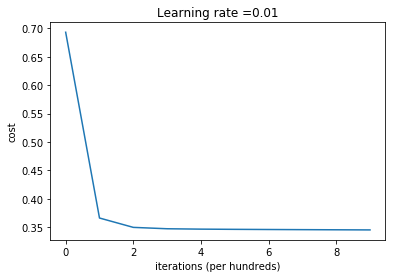

In [275]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

## Regularization

The previous code does not include any regularization (lambda = 0) so it may overfit if we don't carefully setup the features.

In [ ]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, lambda_reg = 10, num_iterations = 1000, learning_rate = 0.01, print_cost = True)

## Visualize the Weights

(784, 1)


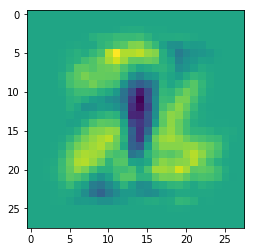

In [283]:
w = d["w"]
print(w.shape)
plt.imshow(w.reshape([28,28]))

## Mini-Batch Gradient Descent

Previously we use Batch Gradient Descent to learn the parameters. To speed up learning, we can use mini-batch gradient descent where each mini-batch is roughly 10% of the training set.

In [305]:
def mb_model(X_train, Y_train, X_test, Y_test, lambda_reg, num_epoch = 10, learning_rate = 0.5, print_cost = True):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    costs_mb = []
    w, b = np.zeros((X_train.shape[0],1)), 0.
    
    for i in range(0,num_epoch):
        for j in range(0,train_set_x.shape[1]-9,9):
            parameters, grads, costs = optimize(w, b, train_set_x[:,j:j+9].reshape(784,9), train_set_y[:,j:j+9].reshape(1,9), lambda_reg, 1, learning_rate, print_cost = True)
            w = parameters["w"]
            b = parameters["b"]
            costs_mb.append(costs)
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs_mb,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate}
    
    return d

In [311]:
d = mb_model(train_set_x, train_set_y, test_set_x, test_set_y, lambda_reg = 0, num_epoch = 50, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 0: 0.684629
Cost after iteration 0: 0.675157
Cost after iteration 0: 0.683648
Cost after iteration 0: 0.674960
Cost after iteration 0: 0.661473
Cost after iteration 0: 0.659112
Cost after iteration 0: 0.633329
Cost after iteration 0: 0.630466
Cost after iteration 0: 0.624055
Cost after iteration 0: 0.638606
Cost after iteration 0: 0.626905
Cost after iteration 0: 0.645231
Cost after iteration 0: 0.626911
Cost after iteration 0: 0.595851
Cost after iteration 0: 0.610412
Cost after iteration 0: 0.620784
Cost after iteration 0: 0.593105
Cost after iteration 0: 0.578956
Cost after iteration 0: 0.591098
Cost after iteration 0: 0.580373
Cost after iteration 0: 0.571321
Cost after iteration 0: 0.544324
Cost after iteration 0: 0.575607
Cost after iteration 0: 0.586823
Cost after iteration 0: 0.539284
Cost after iteration 0: 0.571498
Cost after iteration 0: 0.550895
Cost after iteration 0: 0.539842
Cost after iteration 0: 0.541489
Cost after

Cost after iteration 0: 0.191463
Cost after iteration 0: 0.112463
Cost after iteration 0: 0.234941
Cost after iteration 0: 0.182524
Cost after iteration 0: 0.140804
Cost after iteration 0: 0.173885
Cost after iteration 0: 0.077942
Cost after iteration 0: 0.127746
Cost after iteration 0: 0.130825
Cost after iteration 0: 0.157216
Cost after iteration 0: 0.191111
Cost after iteration 0: 0.257860
Cost after iteration 0: 0.183909
Cost after iteration 0: 0.123581
Cost after iteration 0: 0.223976
Cost after iteration 0: 0.278882
Cost after iteration 0: 0.185823
Cost after iteration 0: 0.144930
Cost after iteration 0: 0.115377
Cost after iteration 0: 0.097084
Cost after iteration 0: 0.145349
Cost after iteration 0: 0.132755
Cost after iteration 0: 0.171675
Cost after iteration 0: 0.187994
Cost after iteration 0: 0.109246
Cost after iteration 0: 0.232049
Cost after iteration 0: 0.179115
Cost after iteration 0: 0.137544
Cost after iteration 0: 0.169557
Cost after iteration 0: 0.075729
Cost after

Cost after iteration 0: 0.140410
Cost after iteration 0: 0.092758
Cost after iteration 0: 0.183881
Cost after iteration 0: 0.219921
Cost after iteration 0: 0.134103
Cost after iteration 0: 0.105530
Cost after iteration 0: 0.072776
Cost after iteration 0: 0.057712
Cost after iteration 0: 0.102057
Cost after iteration 0: 0.091449
Cost after iteration 0: 0.137863
Cost after iteration 0: 0.150540
Cost after iteration 0: 0.074014
Cost after iteration 0: 0.195503
Cost after iteration 0: 0.139948
Cost after iteration 0: 0.099144
Cost after iteration 0: 0.118955
Cost after iteration 0: 0.052465
Cost after iteration 0: 0.091871
Cost after iteration 0: 0.080511
Cost after iteration 0: 0.104213
Cost after iteration 0: 0.169403
Cost after iteration 0: 0.201388
Cost after iteration 0: 0.138710
Cost after iteration 0: 0.091724
Cost after iteration 0: 0.182207
Cost after iteration 0: 0.217410
Cost after iteration 0: 0.132128
Cost after iteration 0: 0.104127
Cost after iteration 0: 0.071333
Cost after

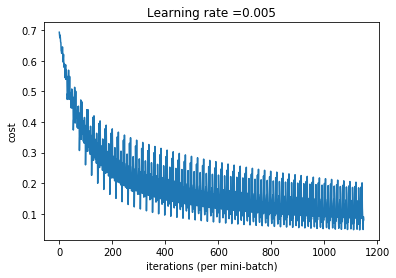

In [312]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per mini-batch)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()